In [1]:
import sys
import multiprocessing as mp
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models
from torchvision.utils import make_grid

from src.utils.dataset import NotStupidRandomResizedCrop, RandomizeBackground, download_dataset, split_dataset, split_dataset_stratified, default_transform, get_dataloaders, image_folder_classes, apply_transforms
from src.utils.visual import show_img, tensor_to_image, postprocess_image, get_noise_image, get_solid_color
from src.utils.training import fit, test_model, load_model, save_model, EarlyStopping
from src.models import Dreamnet50, Googledream, get_model
from src.deepdream import dream_process
from src.utils.config import BEETLENET_MEAN, BEETLENET_STD, get_new_config


# Set up device and workers

In [2]:
# start by setting up device
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# number of threads to handle data. bug makes ipynb hang when num > 0 on windows.
if sys.platform == "linux" or device == 'cpu':
    num_workers = (mp.cpu_count()//2)
else:
    num_workers = 0

# Import data

In [3]:
image_folder = download_dataset() + '/images/'
dataset = datasets.ImageFolder(image_folder)
train_data, val_data, test_data, dataset_sizes = split_dataset_stratified(dataset, 0.8, 0.5)
print(dataset_sizes)

{'train': 8816, 'val': 2205, 'test': 2756}


# Apply transforms and get dataloaders

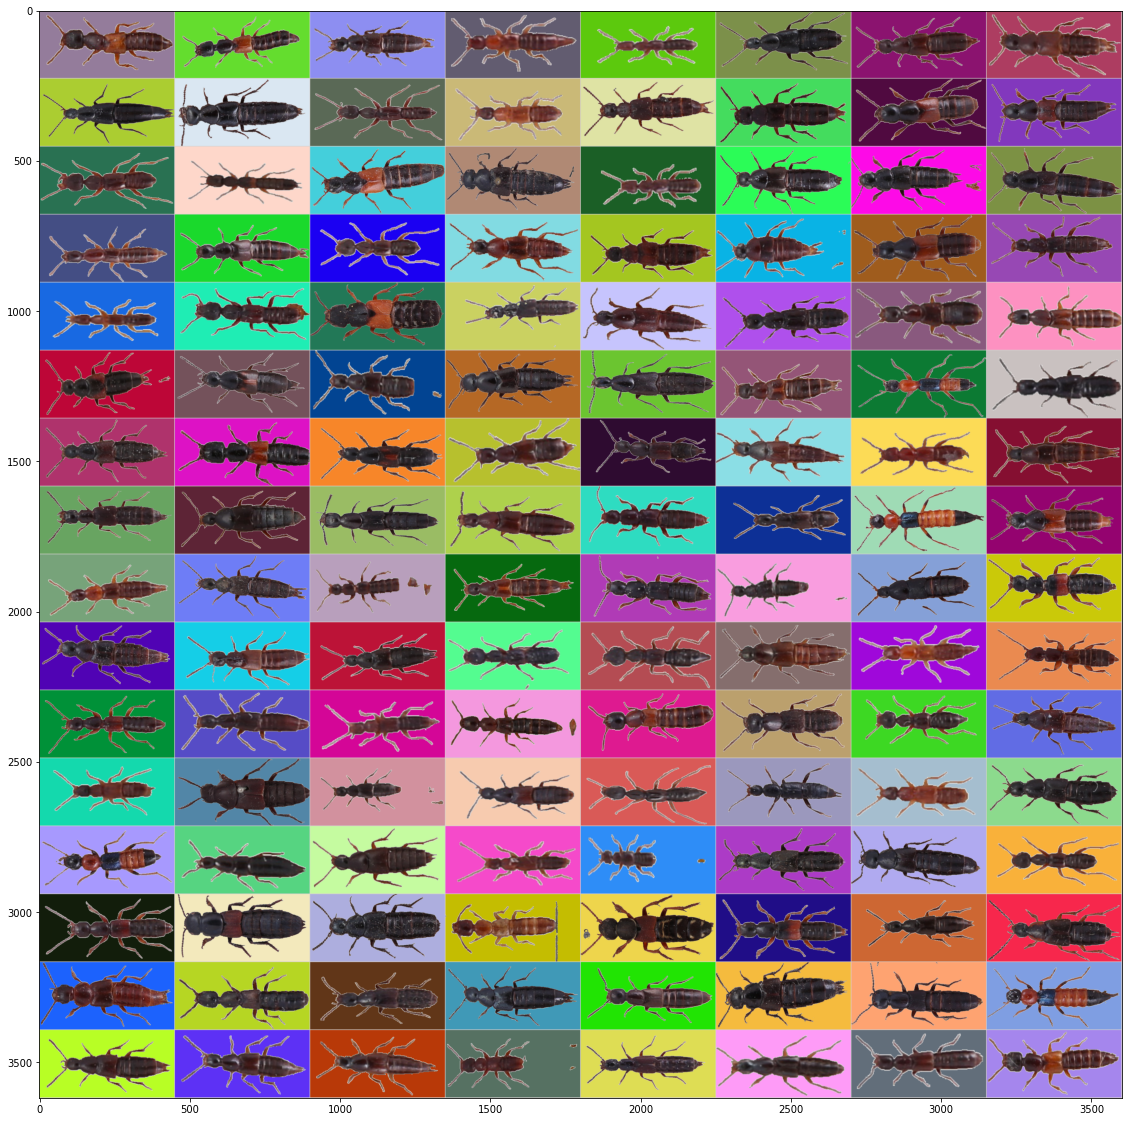

In [4]:
#hypothesis 1: model is underfitting due to model complexity. pick model with less parameters
#hypothesis 2: our data augmentation is not complex enough
from torchvision import transforms

transforms = [
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=(-3,3), fill=255),
    NotStupidRandomResizedCrop(scale=(0.95,1)),
    RandomizeBackground(cutoff=0.95)]

train_dataset, val_dataset, test_dataset = apply_transforms(transforms, train_data, val_data, test_data)

data_loaders = get_dataloaders(train_dataset, val_dataset, test_dataset, batch_size = 32, num_workers = num_workers)
iterable = iter(data_loaders['train'])
images, labels = next(iterable)
tensor_grid = make_grid(images, nrow=8)
image_grid = postprocess_image(tensor_to_image(tensor_grid))
show_img(image_grid, figsize=(20, 20))

# Define classification model

In [5]:
#when transfer learning: num_epochs = 25 min_epochs = 15, patience = 5, 
#train resnet18, resnet34, resnet50 with settings in notebook


num_classes = image_folder_classes(image_folder)
model = get_model('resnet18', pretrained=True,
                  num_classes=num_classes, device=device)
#don't want to clutter fit function with unnecessary arguments, therefore adding dataset folder here
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, eps=0.1)

# Train and or load classification model

Epoch 42/50
----------
Train Loss: 0.5788 Acc: 0.8819
Val Loss: 0.8319 Acc: 0.7891



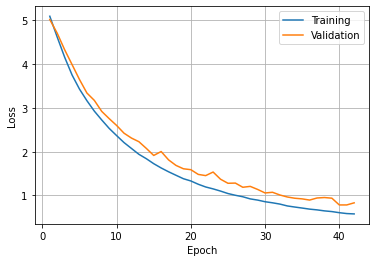

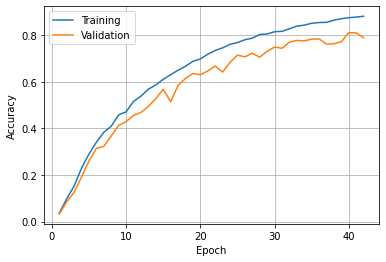

Training complete in 18m 50s
Best val Acc: 0.811338
Accuracy of the network on test images: 81.93 %


In [6]:
#remember to set proper model paths!!!
model_name = 'resnet34_transferlearned'
load = False
if load == True:
    [metrics] = load_model(model, 'models/'+model_name,get_train_metrics = True, device = device)
    print(("test accuracy = %.2f %%" % model.aux_dict['test_acc']))
else:
    metrics = fit(model, data_loaders, dataset_sizes, criterion, optimizer, 
                  EarlyStopping(min_epochs = 35, patience=5, min_delta=0), 
                  num_epochs=50, model_name=model_name, device=device,
                  lr_decay_gamma=0.995, clear='notebook', plot=True, save_interval=1)
    acc = test_model(model, data_loaders['test'])
    save_model(model, path = 'models/'+model_name, train_metrics = metrics)
_ = model.eval()

# Expose layers

In [7]:
#dreamnet = Googledream(model)
dreamnet = Dreamnet50(model)
dreamnet.eval()
print(dreamnet.layers.keys())

dict_keys(['conv1', 'bn1', 'relu', 'maxpool', 'layer1_0', 'layer1_1', 'layer2_0', 'layer2_1', 'layer3_0', 'layer3_1', 'layer4_0', 'layer4_1', 'avgpool', 'fc'])


# Lets dream!

## Choose image

In [8]:
species_name = 'achenium_humile'
example_name = '_0189_0'
image_path = image_folder + species_name + '/' + example_name + '.jpg'
print(image_path)

./data/beetles/images/achenium_humile/_0189_0.jpg


## Choose parameters and apply method

In [13]:
Path("figures").mkdir(parents=True, exist_ok=True)
Path("videos").mkdir(parents=True, exist_ok=True)
params = {
    'input_img_path': None,#image_path,
    'model': dreamnet,
    'mean': BEETLENET_MEAN,
    'std': BEETLENET_STD,
    'out_info': [('fc', None)],
    'num_iters': 200,

    'levels': 4,
    'ratio':1.8,

    'lr': 0.2,
    #'smooth_coef': 0,
    'device': device,
    'noise': 'correlated_gaussian',
    'target_shape': (200, 400),
    'show': False,
    'output_img_path' : 'figures/dreamt_image_'+model_name+'.jpg',
    'video_path': 'videos/dreamt_image_'+model_name+'.gif'
}
config = get_new_config(params)

output_images = dream_process(config)

# params = {'noise': 'correlated_uniform', 'output_img_path': 'figures/dreamt_image_correlated_uniform.jpg'}
# config = get_new_config(params, config)
# for i in range(10):
#     output_images = dream_process(config)
